# EX 10

Develop vector auto regression model for multivariate time series data forecasting.

In [ ]:
pip install yfinance


Step 2: Download Historical Stock Price Data

In [ ]:
import yfinance as yf

# List of stock symbols (you can replace this with the stock symbols from your dataset)
symbols = ['AAPL', 'GOOG', 'MSFT']  # Add more symbols as needed

# Download historical stock price data for each symbol
stock_data = {}
for symbol in symbols:
    stock_data[symbol] = yf.download(symbol, start="2010-01-01", end="2023-01-01")

# Display the data for one of the symbols
print(stock_data['AAPL'].head())


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Price          Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                         
2010-01-04  6.440331  6.455076  6.391278  6.422876  493729600
2010-01-05  6.451465  6.487878  6.417459  6.458085  601904800
2010-01-06  6.348845  6.477044  6.342225  6.451465  552160000
2010-01-07  6.337109  6.379842  6.291066  6.372319  477131200
2010-01-08  6.379241  6.379843  6.291368  6.328684  447610800


Step 3: Preprocess the Data

In [ ]:
import pandas as pd

# Extract the 'Close' prices and align the dates
df_close = pd.DataFrame()
for symbol in symbols:
    df_close[symbol] = stock_data[symbol]['Close']

# Drop any rows with missing values
df_close = df_close.dropna()

# Display the first few rows
print(df_close.head())


                AAPL       GOOG       MSFT
Date                                      
2010-01-04  6.440331  15.536651  23.254051
2010-01-05  6.451465  15.468232  23.261566
2010-01-06  6.348845  15.078298  23.118816
2010-01-07  6.337109  14.727282  22.878376
2010-01-08  6.379241  14.923614  23.036160


Step 4: Check Stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Function to check stationarity using ADF test
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")

# Check stationarity for each stock's Close prices
for symbol in df_close.columns:
    print(f"ADF test for {symbol} Close prices:")
    adf_test(df_close[symbol])
    print("-" * 50)


ADF test for AAPL Close prices:
ADF Statistic: -0.21779671358735178
p-value: 0.9363667819305498
The series is not stationary.
--------------------------------------------------
ADF test for GOOG Close prices:
ADF Statistic: -0.5780248820389924
p-value: 0.8758705933937427
The series is not stationary.
--------------------------------------------------
ADF test for MSFT Close prices:
ADF Statistic: 0.25634457818327255
p-value: 0.9752505221860926
The series is not stationary.
--------------------------------------------------


Step 5: Apply Differencing (if needed)

In [ ]:
# Apply differencing to make the series stationary
df_diff = df_close.diff().dropna()

# Check stationarity again after differencing
for symbol in df_diff.columns:
    print(f"ADF test for differenced {symbol} Close prices:")
    adf_test(df_diff[symbol])
    print("-" * 50)


ADF test for differenced AAPL Close prices:
ADF Statistic: -11.591568055747363
p-value: 2.7838126205253725e-21
The series is stationary.
--------------------------------------------------
ADF test for differenced GOOG Close prices:
ADF Statistic: -13.18628857120727
p-value: 1.1683451237857802e-24
The series is stationary.
--------------------------------------------------
ADF test for differenced MSFT Close prices:
ADF Statistic: -16.03438767278611
p-value: 6.008453439193508e-29
The series is stationary.
--------------------------------------------------


Step 6: Fit the VAR Model

In [ ]:
from statsmodels.tsa.api import VAR

# Fit the VAR model to the differenced data
model = VAR(df_diff)

# Use AIC to determine the optimal lag order
lag_order = model.select_order(maxlags=15).aic
print(f'Optimal lag order: {lag_order}')

# Fit the VAR model with the selected lag order
var_model = model.fit(lag_order)
print(var_model.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimal lag order: 15
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 22, Apr, 2025
Time:                     03:26:31
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   0.927833
Nobs:                     3256.00    HQIC:                  0.762223
Log likelihood:          -14812.6    FPE:                    1.95384
AIC:                     0.669792    Det(Omega_mle):         1.87332
--------------------------------------------------------------------
Results for equation AAPL
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.037133         0.023706            1.566           0.117
L1.AAPL         -0.039218         0.027336           -1.435           0.151
L1.GOOG         -0.019121         0.034920           -0.548

Step 7: Forecasting

In [ ]:
# Number of steps to forecast
forecast_steps = 10

# Generate forecasted values
forecast_values = var_model.forecast(df_diff.values[-lag_order:], steps=forecast_steps)

# Convert forecasted values to a DataFrame
forecast_df = pd.DataFrame(forecast_values,
                           index=pd.date_range(df_diff.index[-1], periods=forecast_steps+1, freq='B')[1:],
                           columns=df_diff.columns)

# Display the forecasted data
print(forecast_df.head())


                AAPL      GOOG      MSFT
2023-01-02 -0.057854  0.506288  1.552534
2023-01-03 -0.265045  0.176771 -0.504087
2023-01-04 -0.086882  0.132421  0.661558
2023-01-05 -0.468745 -0.551070 -0.776199
2023-01-06  0.398532 -0.070032  0.282641


Step 8: Visualize Forecast vs. Actual

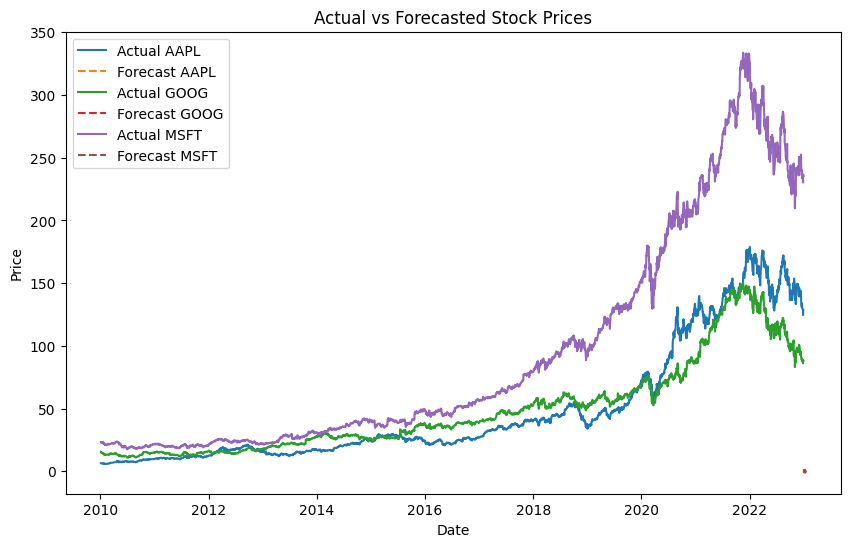

In [ ]:
import matplotlib.pyplot as plt

# Plot the actual vs forecasted values
plt.figure(figsize=(10, 6))
for symbol in df_diff.columns:
    plt.plot(df_close.index, df_close[symbol], label=f'Actual {symbol}')
    plt.plot(forecast_df.index, forecast_df[symbol], label=f'Forecast {symbol}', linestyle='--')

plt.legend()
plt.title('Actual vs Forecasted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


Step 9: Evaluate the Model's Performance (e.g., RMSE)

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE between actual and forecasted values
rmse = np.sqrt(mean_squared_error(df_close[-forecast_steps:], forecast_df))
print(f'RMSE: {rmse}')


RMSE: 163.5085403193716
